In [1]:
import pca_functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import datetime as dt
from stock_data_functions import TickerData,  calc_log_rets
import stock_data_functions
reload(pca_functions)

import scipy.stats as stats
from fredapi import Fred
fred_api = Fred('e48d0413b1cd0a3b30b58d42225373de')

In [393]:
dfs, collected_tickers, try_again = pca_functions.get_all_returns_data()


In [540]:
rth_df = pca_functions.filter_session(dfs, False)
start_date = '2023-10-02'
rth_df = rth_df[rth_df.index.date >= pd.to_datetime(start_date).date()].copy()
rth_df.fillna(0,inplace=True)
daily_rets = rth_df.resample('1D').sum()
hourly_rets = rth_df.resample('1h').sum()


/Users/phillip/Desktop/Moon2/stock_data_functions.py:31: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = df.pct_change().dropna()


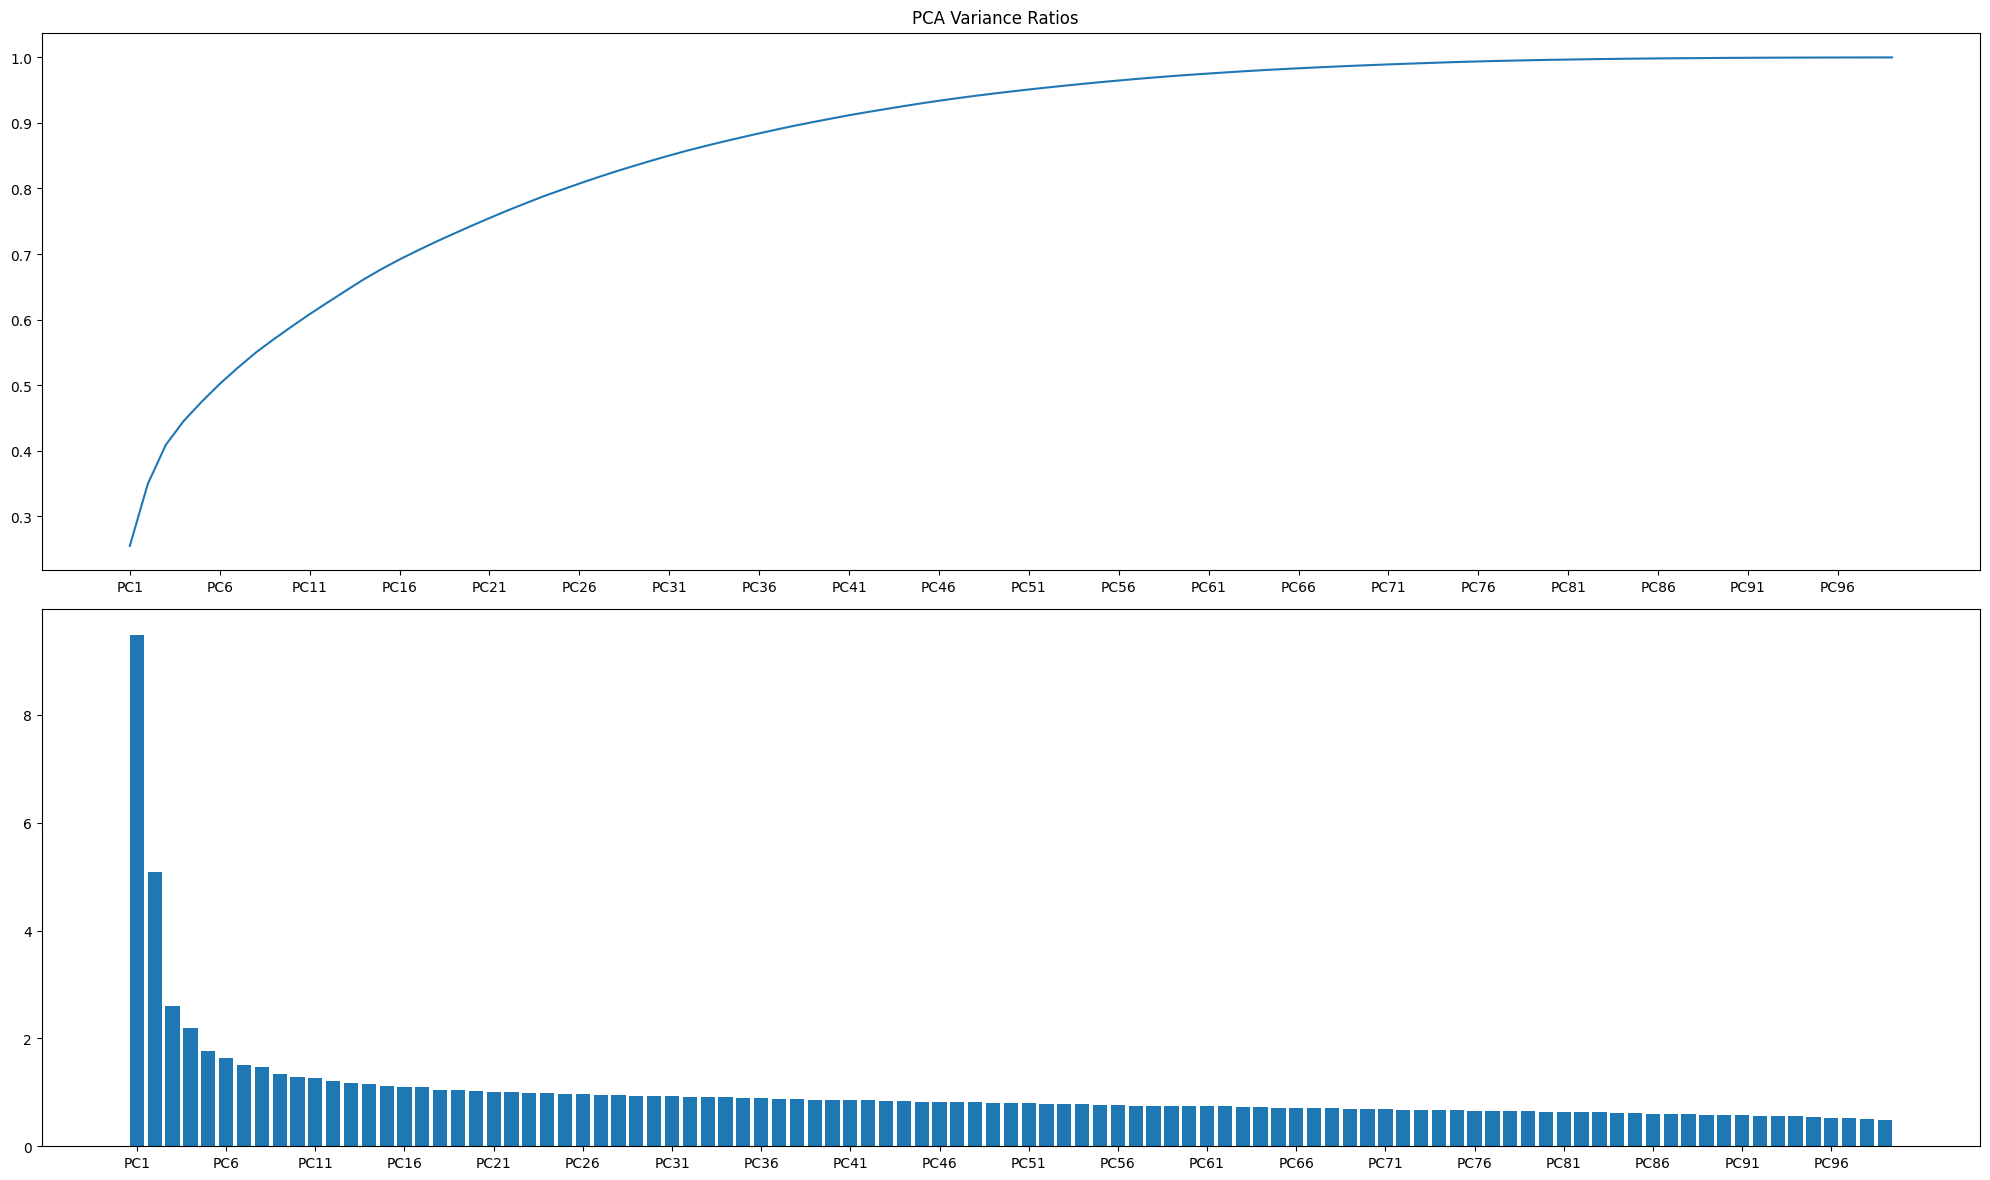

In [462]:
fig, axs = plt.subplots(2,1, figsize=(20,12))
axs[0].plot(top100_pca_var_ratios_daily['cumsum'], label='Explained Variance Ratio')

k = len(top100_pca_var_ratios_daily)
axs[0].set_xticks(np.arange(0, k, 5))
axs[0].set_xticklabels([f"PC{i+1}" for i in range(0, k, 5)])

axs[1].bar(top100_pca_var_ratios_daily.index, eigenvalues['PC'], label='Explained Variance Ratio Contribution')
axs[1].set_xticks(np.arange(0, k, 5))
axs[1].set_xticklabels([f'PC{i+1}' for i in range(0, k,5)])
plt.suptitle('PCA Variance Ratios')
plt.tight_layout()
plt.show();

In [399]:
from matplotlib.dates import AutoDateFormatter, AutoDateLocator, MonthLocator, DateFormatter

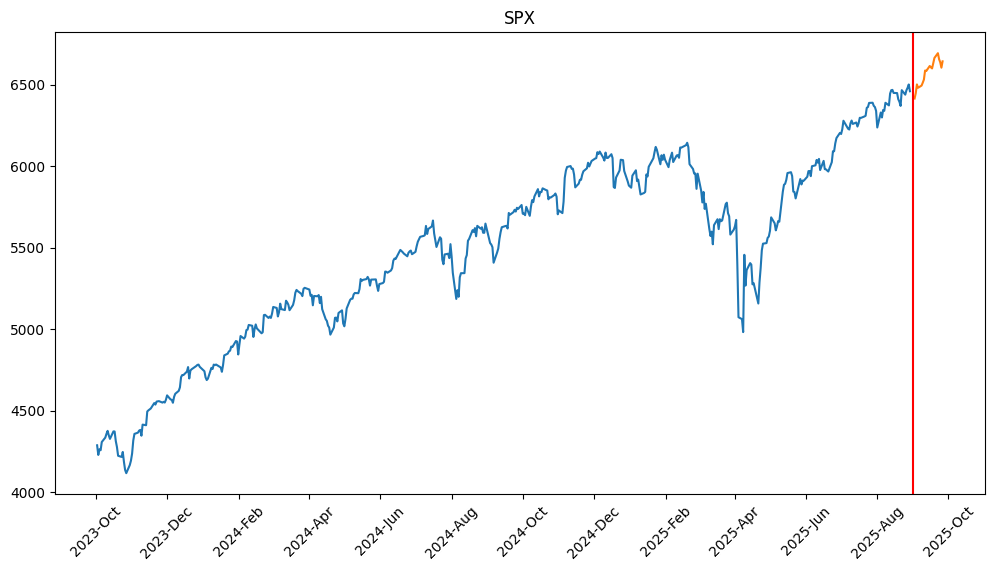

In [545]:
train_end = pd.to_datetime('2025-09-01')

SPX = fred_api.get_series('SP500', observation_start = start_date, observation_end='2025-09-26').to_frame('SPX')
avaliable_dates = set(rth_df.index.strftime('%Y-%m-%d'))
SPX = SPX.reindex(avaliable_dates).dropna() 
SPX = SPX.dropna()
SPX.index = pd.to_datetime(SPX.index)
SPX.sort_index(inplace=True)

train_SPX = SPX.loc[SPX.index < train_end]
test_SPX  = SPX.loc[SPX.index >= train_end]

plt.figure(figsize=(12,6))
plt.plot(train_SPX, color='tab:blue')
plt.plot(test_SPX, color='tab:orange')
plt.axvline(x = train_end, color='red')
plt.title('SPX')

plt.gca().xaxis.set_major_locator(MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%b'))
plt.tick_params(axis = 'x',
                rotation = 45)


Text(0.5, 1.0, 'PC 1 Test')

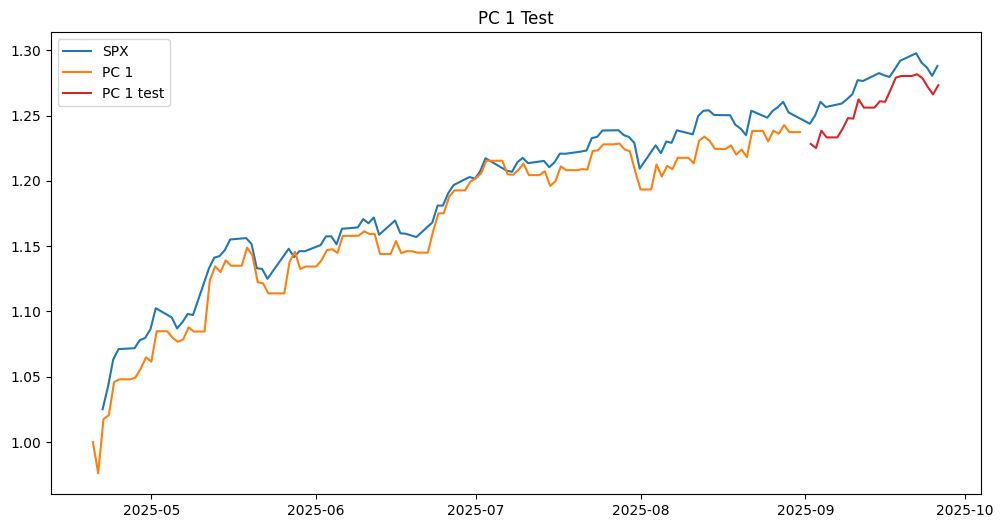

In [490]:
weights_1           = get_pc_weights_from_loadings(top100_pca_loadings_daily, 1)
weights_1_df        = pd.DataFrame(weights_1).T
weighted_rets       = weights_1_df.apply(get_weighted_returns, axis=0).sum(axis=1).to_frame('PC1 rets')
weighted_rets       = weighted_rets / weighted_rets.iloc[0, 0]

weighted_rets_test  = weighted_rets[daily_rets.index.date > train_end.date()].copy()
weighted_rets_train = weighted_rets[daily_rets.index.date < train_end.date()].copy()

SPX_rets = SPX.apply(calc_log_rets)
SPX_rets['Cum Rets'] = SPX_rets['SPX'].cumsum()
SPX_rets['SPX Gains'] = np.exp(SPX_rets['Cum Rets']) 

fig, axs = plt.subplots(1, figsize=(12,6))

axs.plot(SPX_rets['SPX Gains'], label = 'SPX')
axs.plot(weighted_rets_train['PC1 rets'], label='PC 1')
axs.plot(weighted_rets_test['PC1 rets'], label = 'PC 1 test', color='tab:red')
axs.legend()
plt.title('PC 1 Test')

Text(0.5, 1.0, 'PC 2 Test')

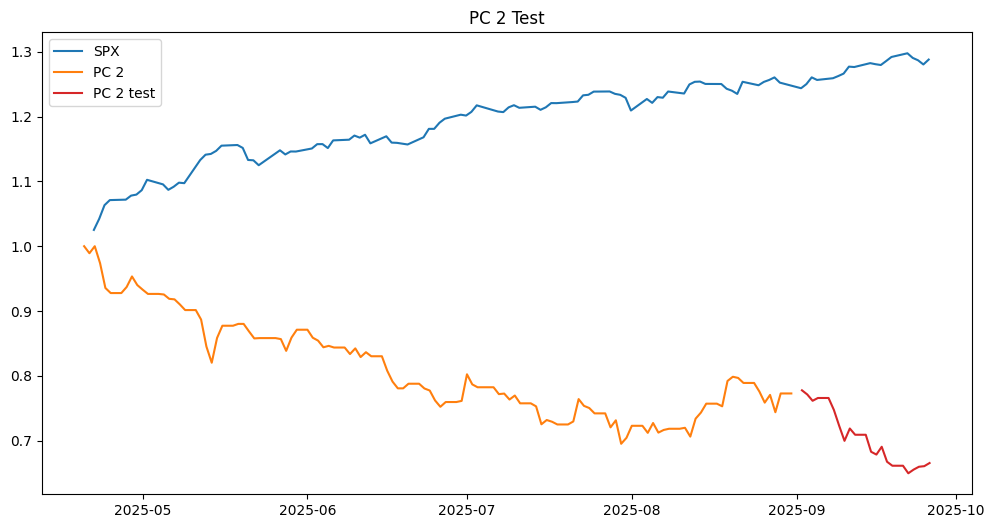

In [491]:
# Initialise weights
n                   = 2
weights_1           = get_pc_weights_from_loadings(top100_pca_loadings_daily, n)
weights_1_df        = pd.DataFrame(weights_1).T
weighted_rets       = weights_1_df.apply(get_weighted_returns, axis=0).sum(axis=1).to_frame(f'PC{n} rets')
weighted_rets       = weighted_rets / weighted_rets.iloc[0, 0]

weighted_rets_test  = weighted_rets[daily_rets.index.date > train_end.date()].copy()
weighted_rets_train = weighted_rets[daily_rets.index.date < train_end.date()].copy()


SPX_rets = SPX.apply(calc_log_rets)
SPX_rets['Cum Rets'] = SPX_rets['SPX'].cumsum()
SPX_rets['SPX Gains'] = np.exp(SPX_rets['Cum Rets']) 

fig, axs = plt.subplots(1, figsize=(12,6))

axs.plot(SPX_rets['SPX Gains'], label = 'SPX')
axs.plot(weighted_rets_train[f'PC{n} rets'], label=f'PC {n}')
axs.plot(weighted_rets_test[f'PC{n} rets'], label = f'PC {n} test', color='tab:red')
axs.legend()
plt.title('PC 2 Test')

Text(0.5, 1.0, 'PC 2 Test')

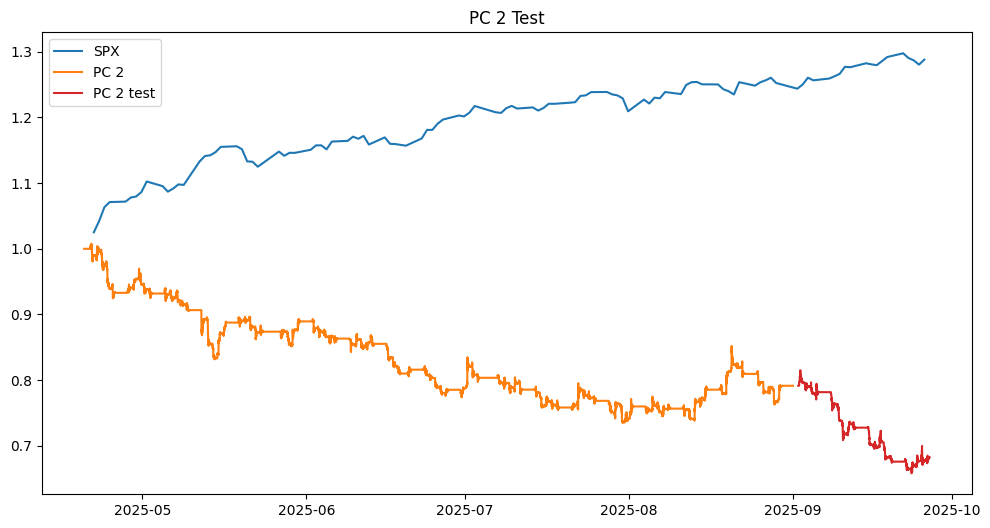

In [496]:
# Initialise weights
n                   = 2
weights_1           = get_pc_weights_from_loadings(top100_pca_loadings, n)
weights_1_df        = pd.DataFrame(weights_1).T
weighted_rets       = weights_1_df.apply(get_weighted_returns, axis=0, args=(rth_df,)).sum(axis=1).to_frame(f'PC{n} rets')
weighted_rets       = weighted_rets / weighted_rets.iloc[0, 0]

weighted_rets_test  = weighted_rets[rth_df.index.date > train_end.date()].copy()
weighted_rets_train = weighted_rets[rth_df.index.date < train_end.date()].copy()


SPX_rets = SPX.apply(calc_log_rets)
SPX_rets['Cum Rets'] = SPX_rets['SPX'].cumsum()
SPX_rets['SPX Gains'] = np.exp(SPX_rets['Cum Rets']) 

fig, axs = plt.subplots(1, figsize=(12,6))

axs.plot(SPX_rets['SPX Gains'], label = 'SPX')
axs.plot(weighted_rets_train[f'PC{n} rets'], label=f'PC {n}')
axs.plot(weighted_rets_test[f'PC{n} rets'], label = f'PC {n} test', color='tab:red')
axs.legend()
plt.title(f'PC {n} Test')

Text(0.5, 1.0, 'PC 3 Test')

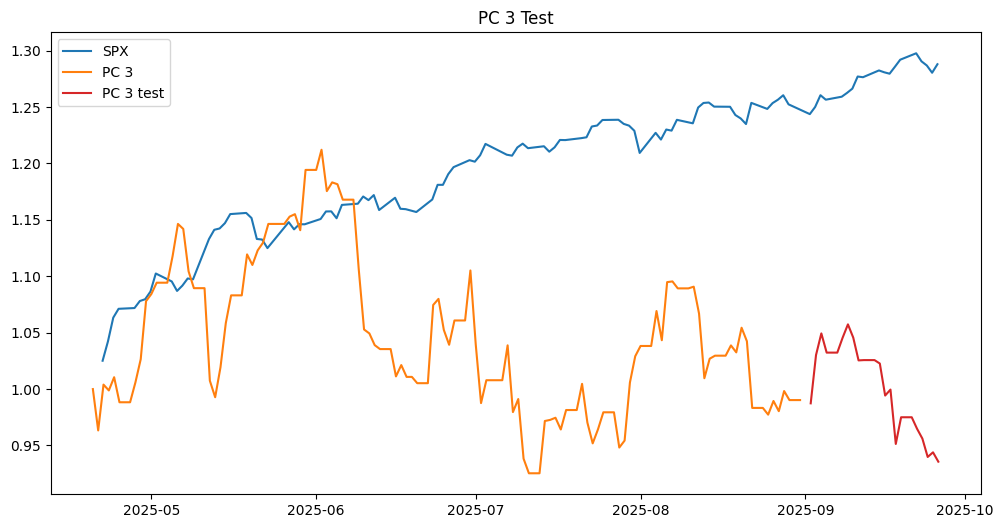

In [495]:
# Initialise weights
n                   = 3
weights_1           = get_pc_weights_from_loadings(top100_pca_loadings_daily, n)
weights_1_df        = pd.DataFrame(weights_1).T
weighted_rets       = weights_1_df.apply(get_weighted_returns, axis=0).sum(axis=1).to_frame(f'PC{n} rets')
weighted_rets       = weighted_rets / weighted_rets.iloc[0, 0]

weighted_rets_test  = weighted_rets[daily_rets.index.date > train_end.date()].copy()
weighted_rets_train = weighted_rets[daily_rets.index.date < train_end.date()].copy()


SPX_rets = SPX.apply(calc_log_rets)
SPX_rets['Cum Rets'] = SPX_rets['SPX'].cumsum()
SPX_rets['SPX Gains'] = np.exp(SPX_rets['Cum Rets']) 

fig, axs = plt.subplots(1, figsize=(12,6))

axs.plot(SPX_rets['SPX Gains'], label = 'SPX')
axs.plot(weighted_rets_train[f'PC{n} rets'], label=f'PC {n}')
axs.plot(weighted_rets_test[f'PC{n} rets'], label = f'PC {n} test', color='tab:red')
axs.legend()
plt.title(f'PC {n} Test')

In [640]:
# Initialise weights
import seaborn as sns 
palette = sns.color_palette("tab10")

good_dates = '2023-10-02'
def plot_pca_vs_benchmark(n : int,
                          daily_rets=daily_rets,
                          hourly_rets=hourly_rets,
                          minute_rets=rth_df,
                          good_dates=good_dates,
                          end_date = '2025-09-26',
                          benchmark_series = SPX,
                          text = 'SPX',
                          colors=palette,
                          output = False):
    
    minute_loadings, minute_var_ratios, minute_eigenvalues   = pca_functions.pca_analysis(False, minute_rets, start_date=good_dates, end_date=end_date)
    hourly_loadings, hourly_var_ratios, hourly_eigenvalues   = pca_functions.pca_analysis(False, hourly_rets, start_date=good_dates, end_date=end_date)
    daily_loadings, daily_var_ratios, daily_eigenvalues      = pca_functions.pca_analysis(False, daily_rets, start_date=good_dates, end_date=end_date)    
        
    minutely_weights           = get_pc_weights_from_loadings(minute_loadings, n)
    hourly_weights             = get_pc_weights_from_loadings(hourly_loadings, n)
    daily_weights              = get_pc_weights_from_loadings(daily_loadings, n)

    weights_minute_df          = pd.DataFrame(minutely_weights).T
    weights_hour_df            = pd.DataFrame(hourly_weights).T
    weights_daily_df           = pd.DataFrame(daily_weights).T

    weighted_rets_daily        = weights_minute_df.apply(get_weighted_returns, axis=0, args=(daily_rets,)).sum(axis=1).to_frame(f'PC{n} rets')
    weighted_rets_daily        = weighted_rets_daily / weighted_rets_daily.iloc[0, 0]

    weighted_rets_hourly       = weights_hour_df.apply(get_weighted_returns, axis=0, args=(hourly_rets,)).sum(axis=1).to_frame(f'PC{n} rets')
    weighted_rets_hourly       = weighted_rets_hourly / weighted_rets_hourly.iloc[0, 0]

    weighted_rets_minute       = weights_daily_df.apply(get_weighted_returns, axis=0, args=(minute_rets,)).sum(axis=1).to_frame(f'PC{n} rets')
    weighted_rets_minute       = weighted_rets_minute / weighted_rets_minute.iloc[0, 0]

    weighted_rets_test_daily   = weighted_rets_daily[daily_rets.index.date > train_end.date()].copy()
    weighted_rets_train_daily  = weighted_rets_daily[daily_rets.index.date < train_end.date()].copy()

    weighted_rets_test_hourly   = weighted_rets_hourly[hourly_rets.index.date > train_end.date()].copy()
    weighted_rets_train_hourly  = weighted_rets_hourly[hourly_rets.index.date < train_end.date()].copy()

    weighted_rets_test_minute   = weighted_rets_minute[minute_rets.index.date > train_end.date()].copy()
    weighted_rets_train_minute  = weighted_rets_minute[minute_rets.index.date < train_end.date()].copy()

    benchmark_rets              = benchmark_series.apply(calc_log_rets)
    benchmark_rets['Cum Rets']  = benchmark_rets.cumsum()
    benchmark_rets['Benchmark Gains'] = np.exp(benchmark_rets['Cum Rets']) 

    fig, axs = plt.subplots(1, figsize=(12,6))
    axs.plot(benchmark_rets['Benchmark Gains'], label=f'{text}', color=colors[0], lw=1.5)

    axs.plot(weighted_rets_test_daily[f'PC{n} rets'], label=f'PC {n} Daily', color=colors[1], ls ='--')
    axs.plot(weighted_rets_train_daily[f'PC{n} rets'], color=colors[1])

    axs.plot(weighted_rets_test_hourly[f'PC{n} rets'], label=f'PC {n} Hourly', color=colors[2], ls ='--')
    axs.plot(weighted_rets_train_hourly[f'PC{n} rets'], color=colors[2])

    axs.plot(weighted_rets_test_minute[f'PC{n} rets'], label=f'PC {n} Minute', color=colors[5], ls ='--')
    axs.plot(weighted_rets_train_minute[f'PC{n} rets'], color=colors[5])

    axs.legend()
    plt.title(f'PC {n} Test')

    if output:
        print('Rets goes daily, hourly, minute in the tuple returned')
        return {'Minute' : [minute_loadings, minute_var_ratios, minute_eigenvalues],
                'Hour'   : [hourly_loadings, hourly_var_ratios, hourly_eigenvalues],
                'Daily'  : [daily_loadings, daily_var_ratios, daily_eigenvalues],
                'Rets'   : [weighted_rets_test_daily, weighted_rets_train_daily,
                            weighted_rets_train_hourly, weighted_rets_train_hourly,
                            weighted_rets_test_minute, weighted_rets_train_minute]}

2023-10-02 00:00:00-04:00 2025-09-26 19:55:00-04:00
2023-10-02 00:00:00-04:00 2025-09-26 19:00:00-04:00
2023-10-02 00:00:00-04:00 2025-09-26 00:00:00-04:00


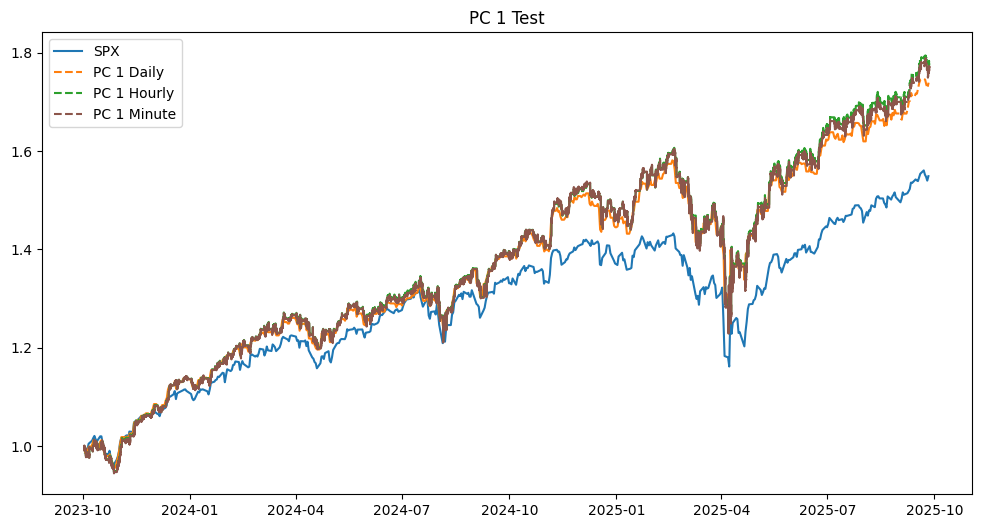

In [557]:
plot_pca_vs_benchmark(1, good_dates=good_dates)

2023-10-02 00:00:00-04:00 2025-09-26 19:55:00-04:00
2023-10-02 00:00:00-04:00 2025-09-26 19:00:00-04:00
2023-10-02 00:00:00-04:00 2025-09-26 00:00:00-04:00


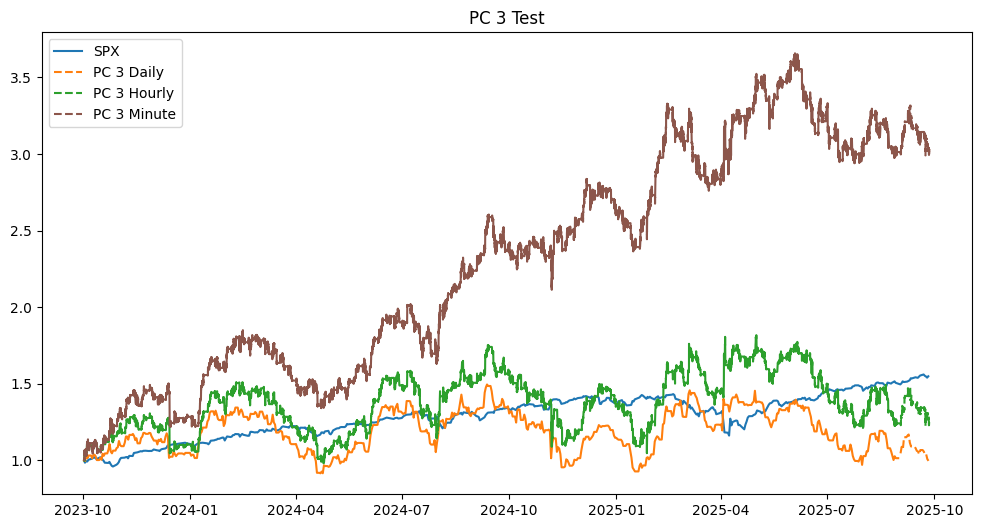

In [549]:
plot_pca_vs_benchmark(3)

2023-10-02 00:00:00-04:00 2025-09-26 19:55:00-04:00
2023-10-02 00:00:00-04:00 2025-09-26 19:00:00-04:00
2023-10-02 00:00:00-04:00 2025-09-26 00:00:00-04:00


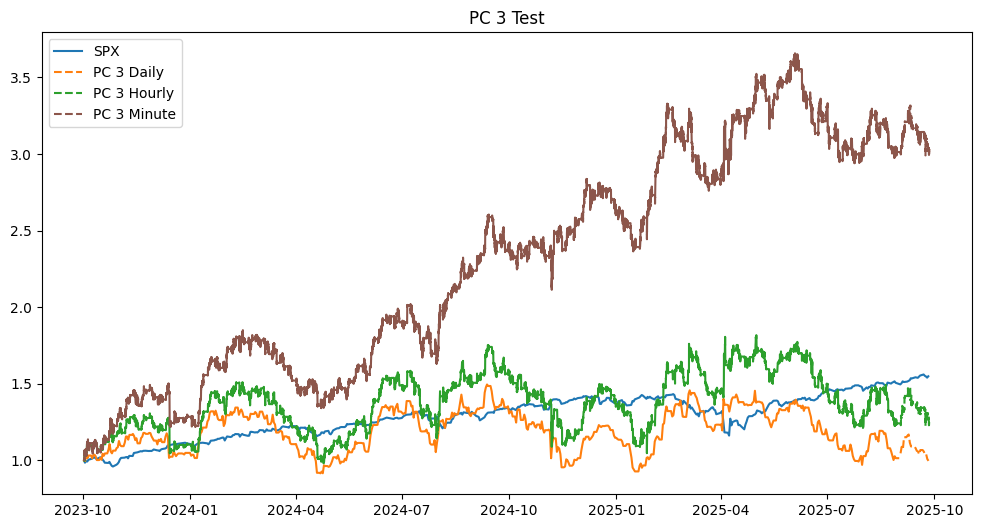

In [620]:
plot_pca_vs_benchmark(3)

2023-10-02 00:00:00-04:00 2025-09-26 19:55:00-04:00
2023-10-02 00:00:00-04:00 2025-09-26 19:00:00-04:00
2023-10-02 00:00:00-04:00 2025-09-26 00:00:00-04:00


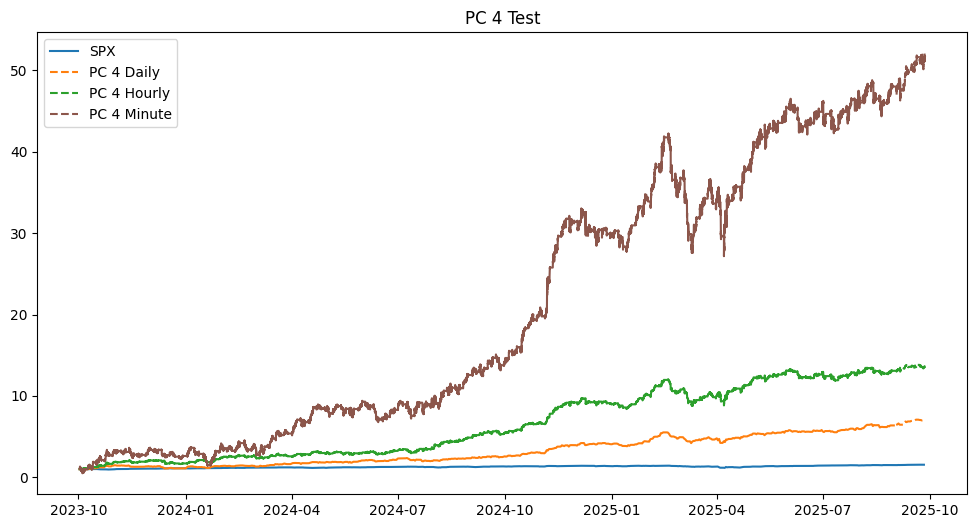

In [621]:
plot_pca_vs_benchmark(4)

In [2]:
from pca_functions import top_stocks_per_pc

In [ ]:
loadings_      = plot_pca_vs_benchmark(n=1, output=True)
daily_pca_dict = loadings_['Daily']
daily_loadings = daily_pca_dict[0]
pc_portfolios  = loadings_['Rets']

In [1]:
top_stocks_daily = top_stocks_per_pc(loadings = daily_loadings, n=20, top =25)
df               = top_stocks_daily.groupby('PC')['Value'].nlargest(15).to_frame()
df               = df.droplevel(1).sort_index()

df.loc['PC2'].sort_values(by='Value', ascending=False)

NameError: name 'top_stocks_per_pc' is not defined

In [806]:
top_stocks_daily = top_stocks_per_pc(loadings = daily_loadings, n=10, top =1000)
df               = top_stocks_daily.groupby('PC')['Value'].nsmallest(12).to_frame()
df               = df.droplevel(1).sort_index()

df.loc['PC7'].sort_values('Value')

,Value
Ticker,
CMCSA,-0.230257
TMUS,-0.205053
IBM,-0.181229
ADBE,-0.169310
INTC,-0.163854
AAPL,-0.156820
MCD,-0.129824
VZ,-0.123577
ACN,-0.122522


In [ ]:
soxx = TickerData('SOXX', filing_date_gte='2023-09-26')
soxx.get_historical_prices()
soxx.calc_zscore_and_rets(earnings=False)

sp_500_health = TickerData('XLV',filing_date_gte='2023-09-01')
sp_500_health.get_historical_prices()
sp_500_health.calc_zscore_and_rets(earnings=False)

sp_500_fin = TickerData('XLF',filing_date_gte='2023-09-01')
sp_500_fin.get_historical_prices()
sp_500_fin.calc_zscore_and_rets(earnings=False)

In [638]:
sp_500_fin.historical_prices['close'].dropna()

bench_marks = pd.DataFrame({
    'SOXX': soxx.historical_prices['close'].dropna(),
    'Health': sp_500_health.historical_prices['close'].dropna(),
    'Fin': sp_500_fin.historical_prices['close'].dropna()
})

In [ ]:
loadings_      = plot_pca_vs_benchmark(n=2, output=True)
pc_portfolios  = loadings_['Rets']  
pc_portfolio_ = pd.concat([pc_portfolios[0], pc_portfolios[1]]).sort_index()
pc_portfolio_.index = pc_portfolio_.index.tz_localize(None)

In [ ]:
df                = pd.concat([pc_portfolio_, cumsum_benchmarks], axis = 1)
df                = df.fillna(1)

In [717]:
import statsmodels.api as sm

X = df[['SOXX', 'Health', 'Fin']].copy()
y = df['PC4 rets']
X = sm.add_constant(X)

reg = sm.OLS(y,X).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               PC4 rets   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     277.5
Date:                Mon, 29 Sep 2025   Prob (F-statistic):          1.05e-119
Time:                        22:17:25   Log-Likelihood:                -1174.9
No. Observations:                 725   AIC:                             2358.
Df Residuals:                     721   BIC:                             2376.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.2965      0.828     13.645      0.000       9.671      12.922
SOXX          -1.7011      0.431     -3.945      0.000      -2.548      -0.855
Health       -14.8081      0.988    -14.989      0.000     -16.748     -12.869
Fin            7.9289      0.348     22.773      0.000       7.245       8.612
==============================================================================
Omnibus:                      122.803   Durbin-Watson:                   0.613
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.646
Skew:                           1.101   Prob(JB):                     8.92e-43
Kurtosis:                       4.248   Cond. No.                         65.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
# --- 0) Benchmarks to pull (name -> ticker) ---
sector_etfs = {
    "CommServ": "XLC", "ConsDisc": "XLY", "ConsStap": "XLP", "Energy": "XLE",
    "Financials": "XLF", "Health": "XLV", "Industrials": "XLI", "Materials": "XLB",
    "RealEstate": "XLRE", "Tech": "XLK", "Utilities": "XLU",
}

theme_etfs = {
    "Semis_SOXX": "SOXX", "Semis_SMH": "SMH",
    "Biotech_IBB": "IBB", "Biotech_XBI": "XBI",
    "Software_IGV": "IGV", "Internet_FDN": "FDN",
    "Cloud_SKYY": "SKYY", "Cloud_CLOU": "CLOU",
    "OilSvc_OIH": "OIH", "Energy_EandP_XOP": "XOP",
    "Banks_KBE": "KBE", "RegBanks_KRE": "KRE",
    "Homebuilders_XHB": "XHB",
    "CleanEnergy_ICLN": "ICLN", "Solar_TAN": "TAN",
    "RoboticsAI_BOTZ": "BOTZ",
}

bench_tickers = {**sector_etfs, **theme_etfs}

def load_benchmark(ticker, start="2023-09-01"):
    t = TickerData(ticker, filing_date_gte=start)
    t.get_historical_prices()
    t.calc_zscore_and_rets(earnings=False)
    # Use 'close' (or 'adj_close' if you have it) and drop NAs
    px = t.historical_prices['close'].dropna()
    px.index = px.index.tz_localize(None) if hasattr(px.index, "tz") and px.index.tz is not None else px.index
    return px, t  # return price series for returns, plus object if you need rets




In [ ]:
# --- 2) Build a price panel for all benchmarks ---
prices = {}
objs = {}


for name, tick in theme_etfs3.items():
    try:
        px, obj = load_benchmark(tick, start="2023-09-01")
        prices[name] = px
        objs[name] = obj
    except Exception as e:
        print(f"FAILED {name} {tick}: {e}")

bench_px_themes3 = pd.concat(prices, axis=1).sort_index()
bench_px_themes3 = bench_px_themes3.loc[:, ~bench_px_themes3.columns.duplicated()]  # just in case

In [787]:
sector_themes = pd.concat([bench_px_themes, bench_px_themes2, bench_px_themes3], axis=1)
sector_themes_cumsum = sector_themes.cumsum()
sector_themes_cumsum = np.exp(sector_themes_cumsum)
sector_themes_cumsum.loc['2023-10-02', :] = np.ones(len(sector_themes_cumsum.columns))
sector_themes_cumsum.sort_index(inplace=True)

In [751]:
bench_px2_cumsum = bench_px2.cumsum()
bench_px2_cumsum = np.exp(bench_px2_cumsum)
bench_px2_cumsum.loc['2023-10-02', :] = np.ones(len(bench_px2_cumsum.columns))
bench_px2_cumsum.sort_index(inplace=True)

2023-10-02 00:00:00-04:00 2025-09-26 19:55:00-04:00
2023-10-02 00:00:00-04:00 2025-09-26 19:00:00-04:00
2023-10-02 00:00:00-04:00 2025-09-26 00:00:00-04:00
Rets goes daily, hourly, minute in the tuple returned


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PC52 rets   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     35.59
Date:                Mon, 29 Sep 2025   Prob (F-statistic):           1.72e-56
Time:                        23:01:34   Log-Likelihood:                -1710.0
No. Observations:                 725   AIC:                             3442.
Df Residuals:                     714   BIC:                             3492.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -56.9467      4.736    -12.023      0.000     -66.246     -47.648
Health         26.4289      5.022      5.262      0.000      16.569      36.289
Industrials    44.6754      7.552      5.916      0.000      29.849      59.501
Materials     -47.8669      7.539     -6.349      0.000     -62.668     -33.065
RealEstate     29.9403      4.295      6.970      0.000      21.507      38.373
Tech           -6.8281      3.448     -1.980      0.048     -13.597      -0.059
CommServ       35.1482      4.872      7.214      0.000      25.583      44.713
ConsDisc       15.2515      2.988      5.104      0.000       9.385      21.118
ConsStap       12.9981      6.222      2.089      0.037       0.783      25.214
Energy         31.5940      4.214      7.497      0.000      23.320      39.868
Financials    -82.3640      6.071    -13.567      0.000     -94.283     -70.445
==============================================================================
Omnibus:                       30.109   Durbin-Watson:                   0.346
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.947
Skew:                           0.520   Prob(JB):                     7.01e-08
Kurtosis:                       3.095   Cond. No.                         442.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

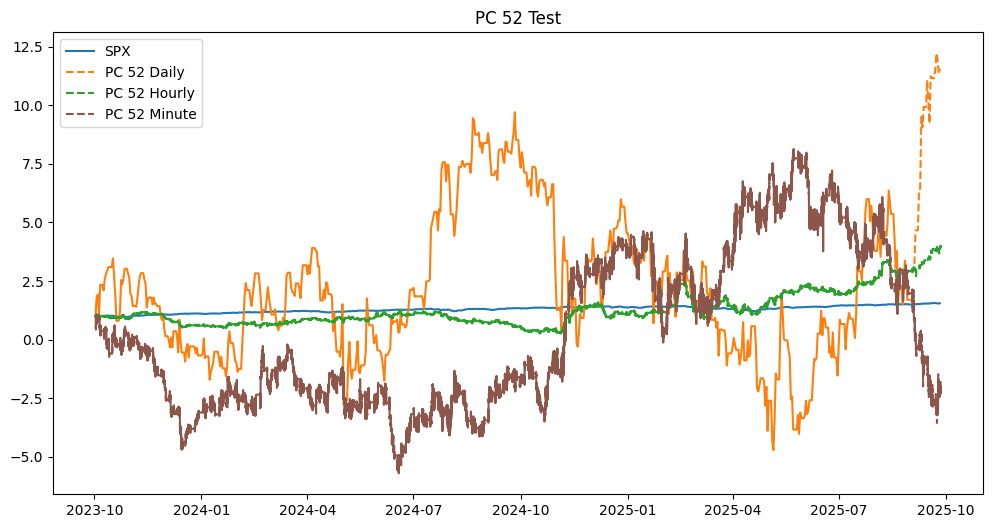

In [834]:
n = 52
loadings_      = plot_pca_vs_benchmark(n=n, output=True)
pc_portfolios  = loadings_['Rets']  
pc_portfolio_ = pd.concat([pc_portfolios[0], pc_portfolios[1]]).sort_index()
pc_portfolio_.index = pc_portfolio_.index.tz_localize(None)

df                = pd.concat([pc_portfolio_, bench_px2_cumsum], axis = 1)
df                = df.fillna(1)

X = df.drop(f'PC{n} rets', axis=1).copy()
y = df[f'PC{n} rets']
X = sm.add_constant(X)

reg = sm.OLS(y,X).fit()
reg.summary()

2023-10-02 00:00:00-04:00 2025-09-26 19:55:00-04:00
2023-10-02 00:00:00-04:00 2025-09-26 19:00:00-04:00
2023-10-02 00:00:00-04:00 2025-09-26 00:00:00-04:00


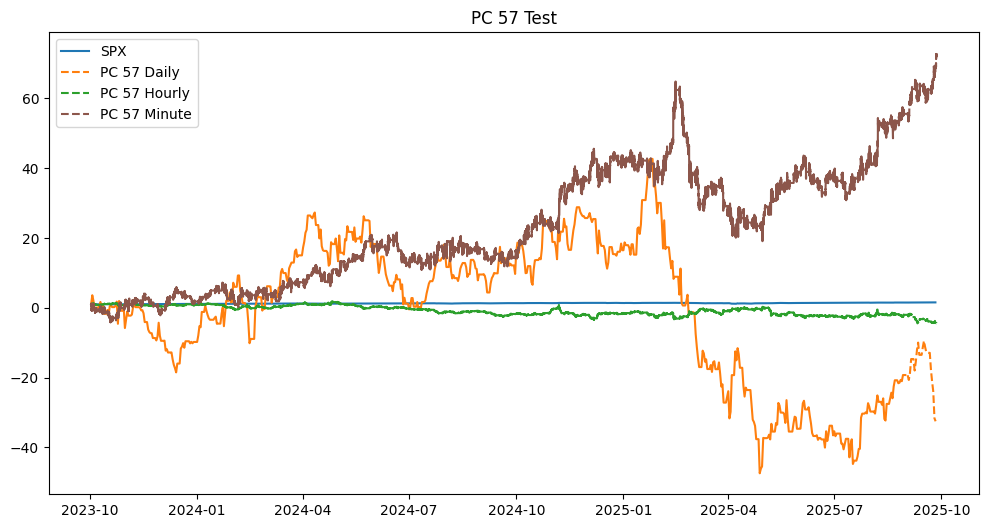

In [836]:
plot_pca_vs_benchmark(n=57)

2023-10-02 00:00:00-04:00 2025-09-26 19:55:00-04:00
2023-10-02 00:00:00-04:00 2025-09-26 19:00:00-04:00
2023-10-02 00:00:00-04:00 2025-09-26 00:00:00-04:00


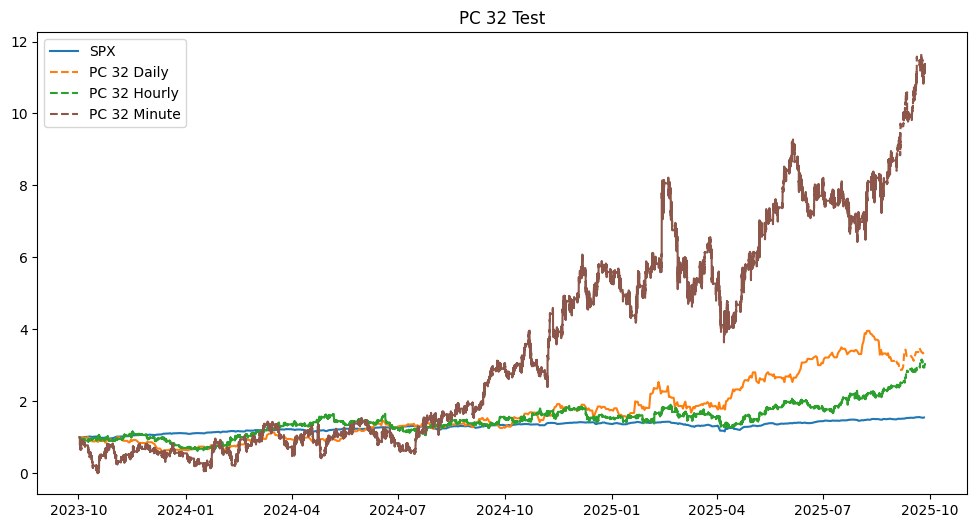

In [837]:
plot_pca_vs_benchmark(n=32)

In [811]:
df2                = pd.concat([bench_px2_cumsum, sector_themes_cumsum], axis = 1)
df2.to_csv('Sector and Theme Rets.csv')

In [829]:
daily_loadings = loadings_['Daily'][0]
aapl = daily_loadings.loc['AAPL'].to_frame()

In [840]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [853]:

normalized_reg = pd.DataFrame(StandardScaler().fit_transform(df2), 
                              index = df2.index,
                              columns = df2.columns)

pca_reg = PCA(n_components=8).fit(normalized_reg)

reg_loadings = pd.DataFrame(pca_reg.components_.T,
                            index = normalized_reg.columns,
                            columns = [f'{i+1}' for i in range(0,8)])

variance_matrix = pd.DataFrame(pca_reg.explained_variance_ratio_,
                               index = reg_loadings.columns,
                               columns = ['Variance Ratio'])
variance_matrix['Cum Sum'] = variance_matrix.cumsum()

In [864]:


def pc_weights_from_loadings(loadings: pd.DataFrame) -> pd.DataFrame:
    """
    Convert loading matrix (tickers × PCs) into weights that sum to 1 per PC.
    loadings: DataFrame indexed by ticker, columns = PCs
    Returns weights: same shape, each column sums to 1.
    """
    # If you want *signed* weights (for long/short)
    w = loadings.div(loadings.sum(axis=0), axis=1)
    return w

def make_pc_portfolios(returns: pd.DataFrame, weights: pd.DataFrame) -> pd.DataFrame:
    """
    Compute PC portfolio returns given stock returns and weights.
    returns: DataFrame indexed by date, columns = tickers
    weights: DataFrame indexed by ticker, columns = PCs (weights sum = 1 per PC)
    Returns: DataFrame indexed by date, columns = PCs (portfolio returns)
    """
    # Align tickers
    common = returns.columns.intersection(weights.index)
    R = returns[common]
    W = weights.loc[common]
    # For each PC, do R × w
    # returns is (T × N); weights is (N × K) → result is (T × K)
    port = R.dot(W)
    return port

# Example usage:
# Suppose `reg_loadings` is your loadings DataFrame, and `df2` is returns
weights = pc_weights_from_loadings(reg_loadings)
pc_portfolios = make_pc_portfolios(df2, weights)

# You can view pc_portfolios.head()


NameError: name 'df2' is not defined